In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Load the data: the Cats vs Dogs dataset

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [3]:
!unzip -q kagglecatsanddogs_5340.zip

File successfully extracted.


### Filter out corrupted images

In [4]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1578 images.


### Generate a Dataset

In [5]:
dataset = datasets.ImageFolder(root='PetImages')

In [6]:
train_size = int(0.8 * len(dataset))
valid_size = train_size -16737
test_size = len(dataset) -  train_size -valid_size
train_dataset,valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size ,test_size])

In [7]:
print(f'train:{len(train_dataset)}')
print(f'test:{len(test_dataset)}')
print(f'valid:{len(valid_dataset)}')

train:18737
test:2685
valid:2000


In [8]:
train_transform= transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.RandomRotation(0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4881, 0.4553, 0.4171),(0.2585, 0.2518, 0.2547))
])

test_transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Normalize((0.4881, 0.4553, 0.4171),(0.2585, 0.2518, 0.2547))
])

In [9]:
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform
valid_dataset.dataset.transform= test_transform

In [10]:
train_loader = DataLoader(train_dataset, batch_size =32, shuffle=True)
test_loader = DataLoader (test_dataset, batch_size= 32, shuffle=False)
valid_loader = DataLoader(valid_dataset,batch_size=32, shuffle=False)

### Build a model

### Train the model

In [17]:
def create_model():
    
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for p in model.parameters():
        p.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1) 
        )

    return model.to(device)

In [18]:
model = create_model()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
summary(model, (3, 180, 180))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 90, 90]          (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 90, 90]          (128)
├─ReLU: 1-3                              [-1, 64, 90, 90]          --
├─MaxPool2d: 1-4                         [-1, 64, 45, 45]          --
├─Sequential: 1-5                        [-1, 64, 45, 45]          --
|    └─BasicBlock: 2-1                   [-1, 64, 45, 45]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 45, 45]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 45, 45]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 45, 45]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 45, 45]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 45, 45]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 45, 45]          --
|    └─BasicBlock: 2-2                   [-1, 64, 45, 45]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 90, 90]          (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 90, 90]          (128)
├─ReLU: 1-3                              [-1, 64, 90, 90]          --
├─MaxPool2d: 1-4                         [-1, 64, 45, 45]          --
├─Sequential: 1-5                        [-1, 64, 45, 45]          --
|    └─BasicBlock: 2-1                   [-1, 64, 45, 45]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 45, 45]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 45, 45]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 45, 45]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 45, 45]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 45, 45]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 45, 45]          --
|    └─BasicBlock: 2-2                   [-1, 64, 45, 45]  

In [20]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=1e-4)

In [21]:
def train (model,loader,critation,optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = critation(outputs.float(), targets.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions = torch.round(torch.sigmoid(outputs))
        total += targets.size(0)
        correct += predictions.eq(targets).sum().item()

    train_loss = running_loss / len(loader)
    train_accuracy = correct / total
    
    
    return train_loss, train_accuracy

In [22]:
def evaluation (model,loader,critation):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets= targets.unsqueeze(1)
            outputs = model(inputs)
            loss = critation(outputs.float(), targets.float())

            running_loss += loss.item()
            predictions = torch.round(torch.sigmoid(outputs))
            total += targets.size(0)
            correct += predictions.eq(targets).sum().item()

    valid_loss = running_loss / len(loader)
    valid_accuracy = correct / total

    return valid_loss, valid_accuracy

In [23]:
num_epochs = 15
epoch_counter = 0
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
best_accuracy = 0.0
patience = 5
epoch_num_improve = 0



for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    valid_loss, valid_accuracy = evaluation(model, valid_loader, criterion)  

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    # if epoch % 5 == 0:
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_accuracy:.4f}")
    print()
    epoch_counter+=1
    
    
    #Early Stopping
    if valid_accuracy > best_accuracy:
      best_accuracy = valid_accuracy
      epoch_num_improve = 0
      torch.save(model.state_dict(), "best_model.pth")
    else:
      epoch_num_improve += 1
      if epoch_num_improve > patience:
        print(f"Early stopping, best accuracy {best_accuracy}")
        break

  7%|▋         | 1/15 [02:23<33:22, 143.07s/it]

Epoch 1/15:
Train Loss: 0.1414 | Train Accuracy: 0.9450
Valid Loss: 0.0794 | Valid Accuracy: 0.9725



 13%|█▎        | 2/15 [05:05<33:29, 154.55s/it]

Epoch 2/15:
Train Loss: 0.1165 | Train Accuracy: 0.9529
Valid Loss: 0.0763 | Valid Accuracy: 0.9720



 20%|██        | 3/15 [07:37<30:40, 153.35s/it]

Epoch 3/15:
Train Loss: 0.1101 | Train Accuracy: 0.9564
Valid Loss: 0.0786 | Valid Accuracy: 0.9670



 27%|██▋       | 4/15 [11:38<34:29, 188.11s/it]

Epoch 4/15:
Train Loss: 0.0997 | Train Accuracy: 0.9606
Valid Loss: 0.0792 | Valid Accuracy: 0.9680



 33%|███▎      | 5/15 [15:04<32:22, 194.27s/it]

Epoch 5/15:
Train Loss: 0.0950 | Train Accuracy: 0.9614
Valid Loss: 0.0808 | Valid Accuracy: 0.9670



 40%|████      | 6/15 [17:52<27:49, 185.45s/it]

Epoch 6/15:
Train Loss: 0.0920 | Train Accuracy: 0.9640
Valid Loss: 0.0717 | Valid Accuracy: 0.9715



 47%|████▋     | 7/15 [19:36<21:10, 158.83s/it]

Epoch 7/15:
Train Loss: 0.0907 | Train Accuracy: 0.9622
Valid Loss: 0.0690 | Valid Accuracy: 0.9740



 53%|█████▎    | 8/15 [20:50<15:23, 131.93s/it]

Epoch 8/15:
Train Loss: 0.0840 | Train Accuracy: 0.9670
Valid Loss: 0.0752 | Valid Accuracy: 0.9685



 60%|██████    | 9/15 [22:05<11:23, 113.93s/it]

Epoch 9/15:
Train Loss: 0.0823 | Train Accuracy: 0.9670
Valid Loss: 0.0740 | Valid Accuracy: 0.9725



 67%|██████▋   | 10/15 [23:19<08:28, 101.77s/it]

Epoch 10/15:
Train Loss: 0.0855 | Train Accuracy: 0.9654
Valid Loss: 0.0709 | Valid Accuracy: 0.9705



 73%|███████▎  | 11/15 [24:34<06:13, 93.37s/it] 

Epoch 11/15:
Train Loss: 0.0778 | Train Accuracy: 0.9680
Valid Loss: 0.0674 | Valid Accuracy: 0.9715



 80%|████████  | 12/15 [26:09<04:42, 94.07s/it]

Epoch 12/15:
Train Loss: 0.0757 | Train Accuracy: 0.9685
Valid Loss: 0.0824 | Valid Accuracy: 0.9675



 80%|████████  | 12/15 [27:24<06:51, 137.03s/it]

Epoch 13/15:
Train Loss: 0.0756 | Train Accuracy: 0.9683
Valid Loss: 0.0672 | Valid Accuracy: 0.9735

Early stopping, best accuracy 0.974


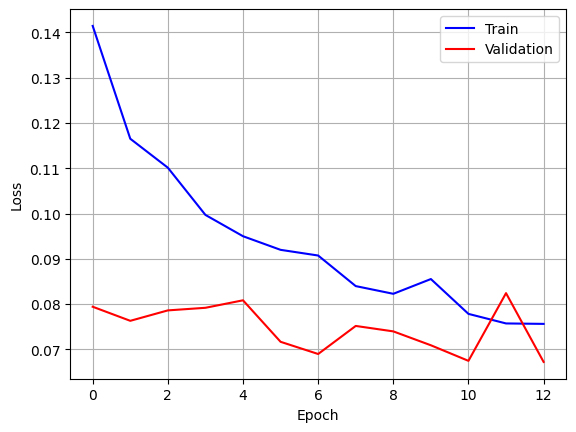

In [25]:
plt.plot(range(13), train_losses, 'b-', label='Train')
plt.plot(range(13), valid_losses, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

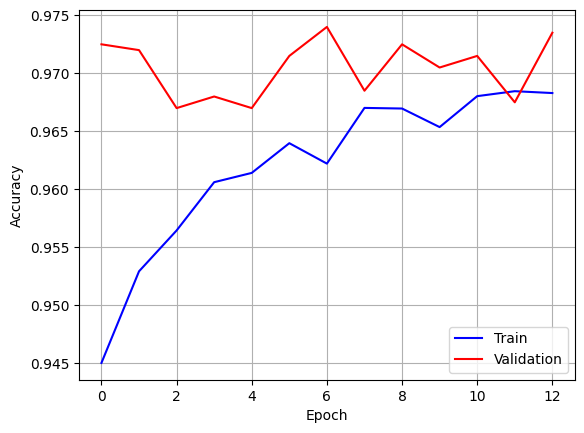

In [26]:
plt.plot(range(13), train_accuracies, 'b-', label='Train')
plt.plot(range(13), valid_accuracies, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

This image is 96.11% cat and 3.89% dog.


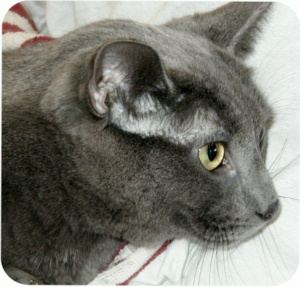

In [27]:
from PIL import Image

img_path = "C:\\Users\\ASUS\\OneDrive\\Desktop\\3\\PetImages\\Cat\\6779.jpg"

img = Image.open(img_path)

transform = transforms.Compose([
    transforms.Resize((180,180)),
    transforms.ToTensor(),
])
img_tensor = transform(img).unsqueeze(0)  

model.eval()  
with torch.no_grad():
    outputs = model(img_tensor.to(device))
score = torch.sigmoid(outputs).item()
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")
img

In [28]:
_, test_accuracy = evaluation(model, test_loader, criterion)
print(f'Test Accuracy={test_accuracy:.4}%')

Test Accuracy=0.9736%
